# Fixing Everything

In [2]:
import os
import random
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import numpy as np


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),  # Resize images and masks to (256, 256)
    transforms.Normalize((0.5,), (0.5,))
])


In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, images_list, masks_dir, transform=None):
        self.images_list = images_list
        self.masks_dir = masks_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        img_path = self.images_list[idx]
        img_name = os.path.basename(img_path)
        
        # Adjust the mask filename here if needed
        mask_name = img_name.replace(".png", ".png")  # Example adjustment
        
        mask_path = os.path.join(self.masks_dir, mask_name)
        
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None or mask is None:
            print(f"Warning: Failed to load image or mask for {img_name}")
            return self.__getitem__((idx + 1) % len(self.images_list))  # Skip this item and get the next one
        
        if self.transform:
            img = self.transform(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
            mask = self.transform(Image.fromarray(mask))
        
        return img, mask


In [5]:
# Define directories
images_dir = '/Users/maryamrehmatulla/Desktop/test_images'
masks_dir = '/Users/maryamrehmatulla/Desktop/test_masks'

# Get list of all images
all_images = [os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.endswith('.png')]

# Split data into train, validation, and test sets (80%, 10%, 10%)
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

print(f'Total images: {len(all_images)}')
print(f'Training images: {len(train_images)}')
print(f'Validation images: {len(val_images)}')
print(f'Testing images: {len(test_images)}')


Total images: 77
Training images: 61
Validation images: 8
Testing images: 8


In [6]:
# Create datasets
train_dataset = SegmentationDataset(train_images, masks_dir, transform=transform)
val_dataset = SegmentationDataset(val_images, masks_dir, transform=transform)
test_dataset = SegmentationDataset(test_images, masks_dir, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Example to check if everything is working
for imgs, masks in train_loader:
    print(imgs.shape, masks.shape)
    break


torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])


# Running the data!

Epoch 1/25, Training Loss: 0.6737, Validation Loss: 0.6681
Epoch 2/25, Training Loss: 0.6641, Validation Loss: 0.6590
Epoch 3/25, Training Loss: 0.6536, Validation Loss: 0.6465
Epoch 4/25, Training Loss: 0.6389, Validation Loss: 0.6282
Epoch 5/25, Training Loss: 0.6120, Validation Loss: 0.5762
Epoch 6/25, Training Loss: 0.4773, Validation Loss: 0.5387
Epoch 7/25, Training Loss: 0.3784, Validation Loss: 0.3829
Epoch 8/25, Training Loss: 0.3580, Validation Loss: 0.3359
Epoch 9/25, Training Loss: 0.3143, Validation Loss: 0.3360
Epoch 10/25, Training Loss: 0.2873, Validation Loss: 0.3180
Epoch 11/25, Training Loss: 0.2783, Validation Loss: 0.3037
Epoch 12/25, Training Loss: 0.2617, Validation Loss: 0.2999
Epoch 13/25, Training Loss: 0.2484, Validation Loss: 0.2890
Epoch 14/25, Training Loss: 0.2362, Validation Loss: 0.2837
Epoch 15/25, Training Loss: 0.2230, Validation Loss: 0.2818
Epoch 16/25, Training Loss: 0.2052, Validation Loss: 0.2746
Epoch 17/25, Training Loss: 0.1823, Validation Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: Invalid shape (1, 256, 256) for image data

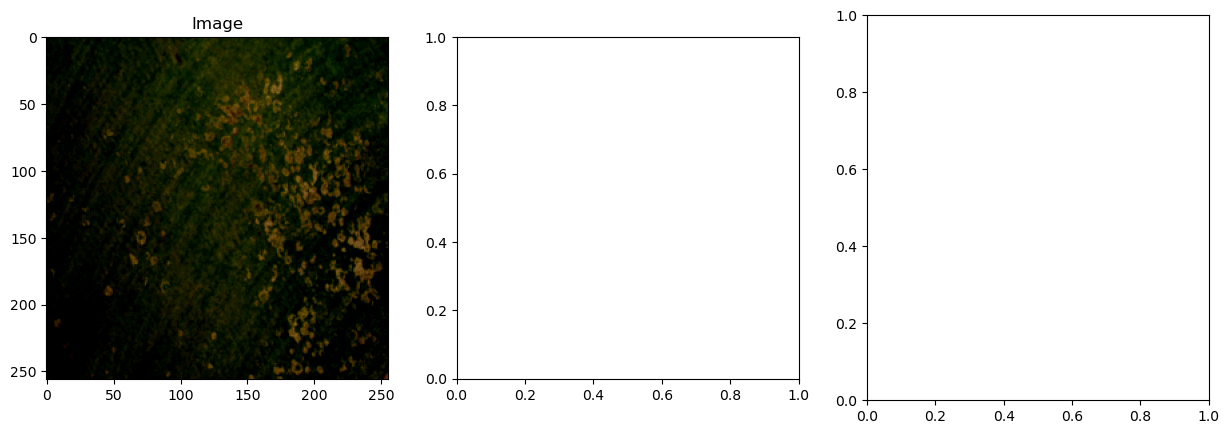

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Import your UNet model
from Model import UNet  # Ensure Model.py is in the same directory or update the path accordingly

# Create datasets
train_dataset = SegmentationDataset(train_images, masks_dir, transform=transform)
val_dataset = SegmentationDataset(val_images, masks_dir, transform=transform)
test_dataset = SegmentationDataset(test_images, masks_dir, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize model, loss function, and optimizer
model = UNet(n_class=1)  # Adjust n_class based on your number of output classes
criterion = nn.BCEWithLogitsLoss()  # or nn.CrossEntropyLoss() if you have more classes
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * imgs.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item() * imgs.size(0)
        
        val_loss /= len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    return model

# Train the model
num_epochs = 25
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

# Evaluate on test set and visualize predictions
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loss = 0.0
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            
            test_loss += loss.item() * imgs.size(0)
    
    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

evaluate_model(trained_model, test_loader)

# Visualize predictions
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader, num_images=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        for i, (imgs, masks) in enumerate(test_loader):
            if i >= num_images:
                break

            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5  # Threshold for binary classification

            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(imgs[0].cpu().numpy().transpose(1, 2, 0))
            ax[0].set_title("Image")
            ax[1].imshow(masks[0].cpu().numpy(), cmap='gray')
            ax[1].set_title("Ground Truth")
            ax[2].imshow(preds[0, 0], cmap='gray')
            ax[2].set_title("Prediction")
            plt.show()

visualize_predictions(trained_model, test_loader)
